##### Author: Ceyda Durmaz
##### Date: December 5, 2020

In [1]:
from graphviz import Digraph

In [2]:
class DBG:
    """ Creates a De Bruijn Graph object of nodes and edges. It
    also stores information on coverage, kmer, kmer length, and the 
    number of incoming/outgoing edges. """
    
    @staticmethod
    def getReads(filename, fileType = "fastq"):
        """ Stores reads as str in a list. Accepts both 'fastq' and 
        'fasta'. """
        # Read in reads file
        readsFile = open(filename)
        reads = readsFile.readlines()
        readsFile.close()

        # Initialize readsList to input to DBG
        readsList = []

        # Set iterR based on fileType
        if fileType == "fastq": 
            iterR = 4
        elif fileType == "fasta":
            iterR = 2

        # Append reads to readsList
        for r in range(0, len(reads), iterR): 
            rStr = reads[r+1]
            rStr = rStr.strip()
            readsList.append(str(rStr))

        return readsList
    
    @staticmethod
    def getKmers(st, k): 
        """ Splits string st into k-mers."""
        k += 1
        for i in range(len(st)-(k-1)):
            yield (st[i:i+k], st[i:i+k-1], st[i+1:i+k])
            
    def addNode(self, n): 
        """ Adds node to graph, incoming edges dictionary, and outgoing 
        edges dictionary. """
        if n not in self.G: 
            self.G[n] = []
        if n not in self.I: 
            self.I[n] = 0
        if n not in self.O:
            self.O[n] = 0
                
    def addEdge(self, start, end, kmer): 
        """ Adds edges to graph and updates incoming/outgoing dicts. 
        Note on tuple order:  0-name, 1-cov, 2-len, 3-kmer. """
        # If both nodes already exist
        if start in self.G and end in self.G: 
            idx, swap = 0, False
            for n in self.G[start]: 
                # If edge exists, replace with new coverage
                if n[0] == end: 
                    newCov = n[1] + 1
                    self.G[start].remove((n[0], n[1], n[2], n[3]))
                    self.G[start].append((n[0], newCov, n[2], n[3]))
                    swap = True
                    break
                idx += 1
            # If edge does not exist
            if swap == False: 
                self.G[start].append((end, 1, len(kmer), kmer))
                self.O[start] = self.O[start] + 1
                self.I[end] = self.I[end] + 1
        # If graph is empty (first edge)
        elif not bool(self.G): 
            self.addNode(start)
            self.addNode(end)
            self.O[start] = 1
            self.I[end] = 1
            self.G[start].append((end, 1, len(kmer), kmer))
        # If start or end node does not exist 
        else: 
            self.addNode(start)
            self.addNode(end)
            self.O[start] = self.O[start] + 1
            self.I[end] = self.I[end] + 1
            self.G[start].append((end, 1, len(kmer), kmer))   
        
    def __init__(self, k, strIter=[], file="", fType="fastq", condense=True): 
        """ Initialize G, I, O, and k. Default is to condense graph. """
        self.G = {} # DBG graph
        self.I = {} # Counts # of incoming edges for each node
        self.O = {} # Counts # of outcoming edges for each node
        self.k = k  # Specified k 
        
        if file and not strIter:
            strIter = self.getReads(filename = file, fileType = fType)
            
        for s in strIter: 
            for kmer, kmL, kmR in self.getKmers(s, k):
                self.addEdge(kmL, kmR, kmer)
                
        if condense: 
            keys = list(self.G.keys())
            for n1 in keys: 
                if n1 in self.G:
                    val = self.G[n1]
                    idx = 0
                    while idx < len(val):
                        n2 = val[idx]
                        if self.I[n2[0]] == 1 and self.O[n2[0]] == 1: 
                            n3 = self.G[n2[0]][0]
                            newKmer = n2[3] + n3[3][-1]
                            newCov = round((n2[1] + n3[1])/2, 2)
                            self.G[n1].remove(n2)
                            del self.G[n2[0]]
                            del self.I[n2[0]]
                            del self.O[n2[0]]
                            self.G[n1].append((n3[0], newCov, len(newKmer), newKmer))
                            idx = 0 
                        else: 
                            idx += 1
                
    def snipTips(self, covCutoff = 10): 
        """ Removes all edges with short length and specified small 
        coverage with tip topological structure. """
        # Get cutoffs
        shortCutoff = 2*self.k
        # Get tips
        tipNodes = []
        for key, val in self.O.items():
            if val == 0: tipNodes.append(key)
        # Get tip edges and remove
        keys = list(self.G.keys())
        for key in keys: 
            if key in self.G: 
                val = self.G[key]
                i = 0
                while i < len(val): 
                    n = val[i] 
                    if n[0] in tipNodes: 
                        if n[1] < covCutoff and n[2] < shortCutoff:
                            self.G[key].remove(n)
                            del self.G[n[0]]
                            del self.I[n[0]]
                            del self.O[n[0]]
                            self.O[key] = self.O[key] - 1
                            i = 0
                    i += 1 
    
    def snipEdges(self, covCutoff = 10, snipLen = True, snipTip = True): 
        """ Removes all edges with coverage below a cutoff. Can remove only 
        bubbles ('snipTip' = False) or all edges ('snipTip' = True). Can also
        specify whether to include length in condition for edge removal ('snipLen'). 
        Best, to have 'snipLen' = False when handeling SNPs. """
        # Get cutoffs
        shortCutoff = 2*self.k
        # Get tips
        tipNodes = []
        for key, val in self.O.items():
            if val == 0: tipNodes.append(key)
        # Get tip edges and remove
        keys = list(self.G.keys())
        for key in keys: 
            if key in self.G: 
                val = self.G[key]
                i = 0
                while i < len(val): 
                    n = val[i] 
                    # Remove tips if specified
                    if snipTip: 
                        if n[0] in tipNodes: 
                            if n[1] < covCutoff and n[2] < shortCutoff:
                                self.G[key].remove(n)
                                del self.G[n[0]]
                                del self.I[n[0]]
                                del self.O[n[0]]
                                self.O[key] = self.O[key] - 1
                                i = 0
                    if snipLen: 
                        # Remove both low covered and short edges
                        if n[0] not in tipNodes and n[1] < covCutoff and n[2] < shortCutoff:
                            self.G[key].remove(n)
                            #del self.G[n[0]]
                            #del self.I[n[0]]
                            #del self.O[n[0]]
                            self.O[key] = self.O[key] - 1
                            i = 0
                    else: 
                        # Remove only low covered edges 
                        if n[0] not in tipNodes and n[1] < covCutoff:
                            self.G[key].remove(n)
                            #del self.G[n[0]]
                            #del self.I[n[0]]
                            #del self.O[n[0]]
                            self.O[key] = self.O[key] - 1
                            i = 0
                    i += 1

 
    def __str__(self): 
        """ Prints out graph. """
        return str(self.G)
    
    def getIn(self):
        """ Prints out incoming edge counts for all nodes. """
        return str(self.I)
    
    def getOut(self):
        """ Prints out outgoing edge counts for all nodes. """
        return str(self.O)
    
    def getEdges(self): 
        """ Returns list of strings of all edges in graphs. """
        outEdges = []
        for val in self.G.values(): 
            for n in val: 
                if n: 
                    outEdges.append(n[3])
        return outEdges
    
    def saveEdges(self, filename):
        """ Saves all edges in graphs as a fasta file as filename. """
        outs = self.getEdges()
        ofile = open(filename, "w")
        for e in range(len(outs)): 
            ofile.write(">" + "edge" + str(e) + "\n" + str(outs[e]) + "\n")
        ofile.close()
    
    def getDot(self): 
        """ Creates dot graph visualization for graph. """
        g = Digraph(comment = 'DeBruijn graph',
                    node_attr = {'color': 'lightblue2', 'style': 'filled'})
        for n in self.G: 
            for neig in self.G[n]:
                g.edge(n, neig[0], label = "Cov: " + str(neig[1]) + "\nLen: " + str(neig[2]))
        return g
    
    def saveDot(self, filename, vis = False):
        """ Outputs dot graph visualization as .dot filename. Can also 
        visualize as pdf if 'vis' is True. """
        self.getDot().render(filename, view = vis)
        

##### Part 1: Build condensed De Bruijn Graph 

In [3]:
# Build De Bruijn Graph
dbg = DBG(file="s_6.first10000.fastq", k=55)

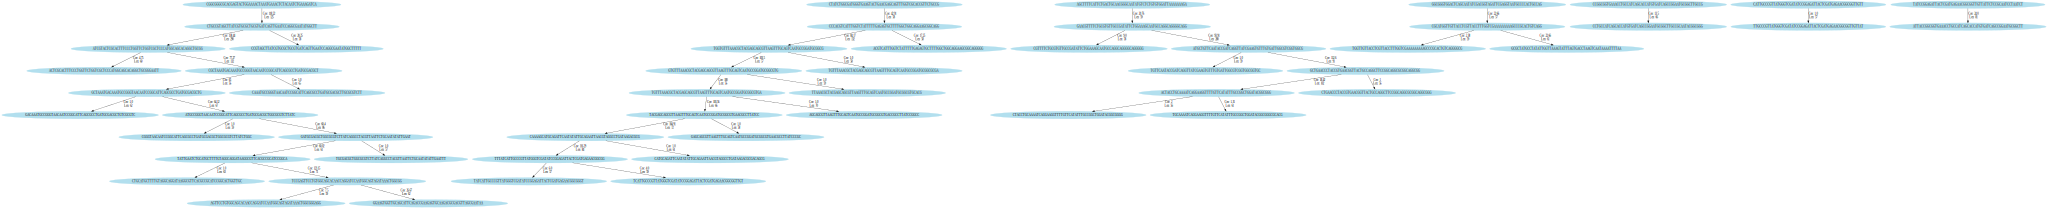

In [4]:
# Visualize dot in notebook
dbg.getDot()

In [5]:
# Save edges as fasta file
dbg.saveEdges("hw3.s_6.first10000.fasta")

In [6]:
# Save dot tree as .dot.file
dbg.saveDot("hw3.s_6.first10000.dot", vis = True)

In [7]:
# Graph Simplification - All edges
dbg.snipEdges()
dbg.saveEdges("hw3.s_6.first10000.rmEdges.fasta")
dbg.saveDot("hw3.s_6.first10000.rmEdges.dot", vis = True)

##### Part 2: Graph Simplification

In [8]:
# Graph Simplification - Tip removal 
dbg = DBG(file="s_6.first10000.fastq", k=55)
dbg.snipTips()
dbg.saveEdges("hw3.s_6.first10000.rmTips.fasta")
dbg.saveDot("hw3.s_6.first10000.rmTips.dot", vis = True)

###### Assess approaches: tip removal vs all low-covered/short edge removal


Tip removal is purposed to remove sequencing errors resulting in a premature end (or branch) of the graph. An all low-covered and short edges removal will handle both tips and bubbles, where an error occurs while still having a path of kmers to connect with the main graph again. Without a reference genome, tips are emoved only if the branch has a coverage shorter than k*2 and is below a defined coverage. To specifically remove bubbles, a comparison between the two diverging path's coverages is required where the lower-covered edge would be eliminated. 

In sequencing, tip removals typically are used to remove sequencing errors while bubble removal is used to account for SNPs or indels. However, there are risks to using one or both methods that is dependent on knowledge of reference. If only removing tips, there is the risk of introducing ambiguity to the graph due to not accounting for SNPs or indels. If removing only bubbles, there is the risk of introducing ambiguity to the graph due to sequencing errors or end position SNPs/indels. If using both, however, there is a risk of removing a main graph tip without errors that just happened to be low covered.  

Below, is a short example of cases when to use and when not to use either tip removal, bubble removal, or all. 

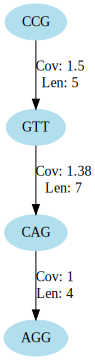

In [9]:
strList = ["CCGTTG", "CGTTACAG", "GTTGCA","TGCAGG"]
g = DBG(strIter = strList, k = 3, condense = True)

# Only bubble removal - best case, as tip is low covered but still part of main graph
g.snipEdges(covCutoff=1.1, snipLen=False, snipTip=False)
g.getDot()

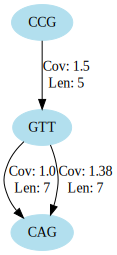

In [10]:
strList = ["CCGTTG", "CGTTACAG", "GTTGCA", "TGCAGG"]
g = DBG(strIter = strList, k = 3, condense = True)

# Only tip removal - worst case as removes tip which is part of main graph but does not
# account for bubble
g.snipTips(covCutoff=1.1)
g.getDot()

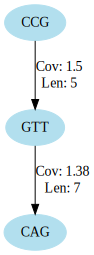

In [11]:
strList = ["CCGTTG", "CGTTACAG", "GTTGCA", "TGCAGG"]
g = DBG(strIter = strList, k = 3, condense = True)

# Remove both tips and bubbles - ok case, as it removes bubble with SNP but also removes tip
# which was part of main graph
g.snipEdges(covCutoff=1.1, snipLen=False, snipTip=True)
g.getDot()